# 04 Uplift Modeling (S/T/X-Learner)

This notebook follows Phase 2 MVP 2.4: CATE estimation via S-Learner / T-Learner / X-Learner.

In [8]:
# ======================================================
# Section 0 (Cell 1/1): Setup
# ======================================================

import os
import sys
from pathlib import Path
from datetime import datetime, timezone, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import importlib
from IPython.display import Markdown, display

from sklearn.model_selection import train_test_split

# Timezone anchoring for reproducibility
TZ_UTC8 = timezone(timedelta(hours=8))
run_ts_utc8 = datetime.now(TZ_UTC8).strftime('%Y-%m-%d %H:%M:%S %z')
print(f"[UTC+8] Run timestamp: {run_ts_utc8}")

# Project root resolution (avoid hardcoding)
project_root = Path.cwd()
if project_root.name == 'notebooks':
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
os.chdir(project_root)

# Plot style
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 13
sns.set_palette('Set2')

# Load config (config.yml / config.yaml)
config_candidates = [project_root / 'configs' / 'config.yaml', project_root / 'configs' / 'config.yml']
config_path = next((p for p in config_candidates if p.exists()), None)
if config_path is None:
    raise FileNotFoundError(f"No config file found. Searched: {[str(p) for p in config_candidates]}")
with open(config_path, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

features_path = Path(config['paths']['features_data'])
assert features_path.exists(), f"Feature file not found: {features_path}"

figures_dir = Path(config['paths'].get('figures_dir', 'outputs/figures/'))
figures_dir.mkdir(parents=True, exist_ok=True)
print(f"Figures will be saved to: {figures_dir}")

# Load features
df = pd.read_csv(features_path)
assert isinstance(df, pd.DataFrame) and len(df) > 0, "Loaded features DataFrame is empty"
print(f"Loaded: {features_path}")

treatment_col = config['data']['treatment_col']
outcome_col = config['data']['outcome_col']
spend_col = config['data']['spend_col']
covariates = config['data']['covariates']

missing_covs = [c for c in covariates if c not in df.columns]
assert len(missing_covs) == 0, f"Missing covariates in df: {missing_covs}"
assert treatment_col in df.columns, f"Missing required column: {treatment_col}"
assert outcome_col in df.columns, f"Missing required column: {outcome_col}"
assert spend_col in df.columns, f"Missing required column: {spend_col}"

# Split X, T, Y
X = df[covariates].copy()
T = pd.to_numeric(df[treatment_col], errors='coerce').astype(int)
Y = pd.to_numeric(df[outcome_col], errors='coerce').astype(int)

assert X.isnull().sum().sum() == 0, "X contains NaN"
assert set(pd.unique(T)).issubset({0, 1}), "T must be binary (0/1)"
assert set(pd.unique(Y)).issubset({0, 1}), "Y must be binary (0/1)"

# Load or compute PS vector
# Requests "load features + PS vector"; if the persisted PS artifact is not found,
# we compute PS via LogisticRegression (estimate_ps) and persist it for reproducibility.
ps_path = Path(config['paths'].get('ps_data', 'data/processed/hillstrom_ps.csv'))
ps = None
if ps_path.exists():
    ps_df = pd.read_csv(ps_path)
    if 'ps' not in ps_df.columns:
        raise ValueError(f"PS file missing 'ps' column: {ps_path}")
    ps = pd.to_numeric(ps_df['ps'], errors='coerce').to_numpy(dtype=float)
    if len(ps) != len(df):
        raise ValueError(f"PS length mismatch: len(ps)={len(ps)} vs len(df)={len(df)}")
    print(f"Loaded PS vector from: {ps_path}")
else:
    from src.causal import estimate_ps
    ps, _ = estimate_ps(X, T, random_state=int(config.get('general', {}).get('random_state', 42)))
    ps_out = pd.DataFrame({'ps': ps.astype(float)})
    ps_path.parent.mkdir(parents=True, exist_ok=True)
    ps_out.to_csv(ps_path, index=False)
    print(f"Computed PS vector and saved to: {ps_path}")

ps = np.asarray(ps, dtype=float).reshape(-1)
assert np.isfinite(ps).all(), "ps contains NaN/inf"
assert ps.min() >= 0.0 and ps.max() <= 1.0, "ps must be within [0, 1]"

# Train/Test split (architecture review adjustment #6)
X_train, X_test, T_train, T_test, Y_train, Y_test, ps_train, ps_test = train_test_split(
    X,
    T,
    Y,
    ps,
    test_size=0.3,
    random_state=int(config.get('general', {}).get('random_state', 42)),
    stratify=T,
)

assert len(X_train) == len(T_train) == len(Y_train) == len(ps_train), "Train split length mismatch"
assert len(X_test) == len(T_test) == len(Y_test) == len(ps_test), "Test split length mismatch"

print(
    f"df.shape={df.shape} | X.shape={X.shape} | "
    f"train={X_train.shape} | test={X_test.shape} | "
    f"T.mean(full)={T.mean():.4f} | T.mean(train)={np.mean(T_train):.4f} | T.mean(test)={np.mean(T_test):.4f}"
)
print(f"ps.mean(full)={ps.mean():.4f} | ps.std(full)={ps.std():.4f}")
print(f"Covariates (n={len(covariates)}): {covariates}")


[UTC+8] Run timestamp: 2026-02-24 15:43:26 +0800
Figures will be saved to: outputs\figures
Loaded: data\processed\hillstrom_features.csv
Loaded PS vector from: data\processed\hillstrom_ps.csv
df.shape=(64000, 16) | X.shape=(64000, 9) | train=(44800, 9) | test=(19200, 9) | T.mean(full)=0.6671 | T.mean(train)=0.6671 | T.mean(test)=0.6671
ps.mean(full)=0.6671 | ps.std(full)=0.0039
Covariates (n=9): ['recency', 'history', 'mens', 'womens', 'newbie', 'channel_Phone', 'channel_Web', 'zip_Surburban', 'zip_Urban']


## Section 1: S-Learner

In [10]:
# ======================================================
# Section 1 (Cell 1/1): Fit S-Learner on train, predict CATE on test
# ======================================================

import src.uplift
importlib.reload(src.uplift)
from src.uplift import fit_s_learner

n_estimators = config['uplift']['n_estimators']
max_depth = config['uplift']['max_depth']
random_state = config['general']['random_state']

cate_s = fit_s_learner(
    X_train,
    T_train,
    Y_train,
    X_pred=X_test,
    n_estimators=n_estimators,
    max_depth=max_depth,
    random_state=random_state,
)

assert isinstance(cate_s, np.ndarray), 'cate_s must be a numpy.ndarray'
assert len(cate_s) == len(X_test), 'CATE length must match test sample size'
assert np.isfinite(cate_s).all(), 'CATE contains NaN/inf'

cate_s_series = pd.Series(cate_s, name='cate_s')
display(cate_s_series.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).to_frame().T)

max_abs = float(np.max(np.abs(cate_s)))
print(f"max(|cate_s|) = {max_abs:.6f}")
if max_abs > 0.10:
    print('[DQ] CATE magnitude > 0.10. Check model calibration / leakage / feature pipeline.')

# Expected scale (Hillstrom RCT): roughly within [-0.02, 0.02]
print(f"Expected (RCT) rough range: [-0.02, 0.02] | observed min={cate_s.min():.6f}, max={cate_s.max():.6f}")


,count,mean,std,min,1%,5%,50%,95%,99%,max
cate_s,19200.0,0.004402,0.004021,-0.011254,-0.003266,-0.000601,0.00377,0.011537,0.018345,0.036114


max(|cate_s|) = 0.036114
Expected (RCT) rough range: [-0.02, 0.02] | observed min=-0.011254, max=0.036114


### Section 1 Summary

**Model**: S-Learner

**Workflow**: S-Learner 是基于单模型的 CATE 估计方法。

1) (训练单一模型) 把 Treatment 作为特征，训练模型 f(x, T)
2) (反事实预测) 对所有用户分别强制计算 f(x, T=1) 和 f(x, T=0)
3) (计算 CATE) τ(x) = f(x, T=1) - f(x, T=0)

**Advantage**: 训练简单，无需复杂的数据训练流程

**Disadvantage**: 当 treatment 效应较小时（如本数据集的 RCT 场景），模型可能忽略 T 特征（正则化将其系数压向零），导致 τ(x) ≈ 0（如此处 CATE 均值为 0.0044，这属于该模型的结构性缺陷，非实现 BUG）

后续的 **T-Learner** 通过分离建模来规避这一问题。

## Section 2: T-Learner

In [12]:
# ======================================================
# Section 2 (Cell 1/1): Fit T-Learner on train, predict CATE on test
# ======================================================

import src.uplift
importlib.reload(src.uplift)
from src.uplift import fit_t_learner

n_estimators = config['uplift']['n_estimators']
max_depth = config['uplift']['max_depth']
random_state = config['general']['random_state']

cate_t = fit_t_learner(
    X_train,
    T_train,
    Y_train,
    X_pred=X_test,
    n_estimators=n_estimators,
    max_depth=max_depth,
    random_state=random_state,
)

assert isinstance(cate_t, np.ndarray), 'cate_t must be a numpy.ndarray'
assert len(cate_t) == len(X_test), 'CATE length must match test sample size'
assert np.isfinite(cate_t).all(), 'CATE contains NaN/inf'

cate_t_series = pd.Series(cate_t, name='cate_t')
display(cate_t_series.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).to_frame().T)

max_abs = float(np.max(np.abs(cate_t)))
print(f"max(|cate_t|) = {max_abs:.6f}")
if max_abs > 0.10:
    print('[DQ] CATE magnitude > 0.10. Check model calibration / leakage / feature pipeline.')

# Expected scale (Hillstrom RCT): roughly within [-0.02, 0.02]
print(f"Expected (RCT) rough range: [-0.02, 0.02] | observed min={cate_t.min():.6f}, max={cate_t.max():.6f}")


,count,mean,std,min,1%,5%,50%,95%,99%,max
cate_t,19200.0,0.005302,0.00568,-0.025868,-0.00808,-0.002134,0.004505,0.015377,0.024571,0.047489


max(|cate_t|) = 0.047489
Expected (RCT) rough range: [-0.02, 0.02] | observed min=-0.025868, max=0.047489


### Section 2 Summary

**Model**: T-Learner

**Workflow**: T-Learner 是基于两个独立模型的 CATE 估计方法。

1) (分组训练模型) 分别在 Treatment 和 Control 组上训练两个模型 μ₁ 和 μ₀
2) (反事实预测) 分别用 μ₁ 和 μ₀ 预测 Treatment 和 Control 组的效应
   - μ₁(x) = E[Y | x, T=1]
   - μ₀(x) = E[Y | x, T=0]
3) (计算 CATE) τ(x) = μ₁(x) - μ₀(x)

**Advantage**: 直观上，当 treatment 效应较小且模型容易忽略 T 特征时，T-Learner 通常比 S-Learner 更容易"看到"两组 outcome 模型的差异

**Disadvantage**: 通过两个独立模型计算 CATE，可能会导致误差进一步增大

后续的 **X-Learner** 通过分离建模、交叉估计与 PS 加权来规避这一问题，并在不平衡样本（T:C=2:1）下更具理论优势。

## Section 3: X-Learner

In [13]:
# ======================================================
# Section 3 (Cell 1/1): Fit X-Learner on train, predict CATE on test
# ======================================================
import src.uplift
importlib.reload(src.uplift)
from src.uplift import fit_x_learner

n_estimators = config['uplift']['n_estimators']
max_depth = config['uplift']['max_depth']
random_state = config['general']['random_state']

cate_x = fit_x_learner(
    X_train,
    T_train,
    Y_train,
    ps_train,
    X_pred=X_test,
    ps_pred=ps_test,
    n_estimators=n_estimators,
    max_depth=max_depth,
    random_state=random_state,
)

assert isinstance(cate_x, np.ndarray), 'cate_x must be a numpy.ndarray'
assert len(cate_x) == len(X_test), 'CATE length must match test sample size'
assert np.isfinite(cate_x).all(), 'CATE contains NaN/inf'

cate_x_series = pd.Series(cate_x, name='cate_x')
display(cate_x_series.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).to_frame().T)

max_abs = float(np.max(np.abs(cate_x)))
print(f"max(|cate_x|) = {max_abs:.6f}")
if max_abs > 0.10:
    print('[DQ] CATE magnitude > 0.10. Check model calibration / leakage / feature pipeline.')

# Expected scale (Hillstrom RCT): roughly within [-0.02, 0.02]
print(f"Expected (RCT) rough range: [-0.02, 0.02] | observed min={cate_x.min():.6f}, max={cate_x.max():.6f}")


,count,mean,std,min,1%,5%,50%,95%,99%,max
cate_x,19200.0,0.004494,0.005865,-0.065357,-0.012522,-0.003793,0.004372,0.013121,0.023036,0.046513


max(|cate_x|) = 0.065357
Expected (RCT) rough range: [-0.02, 0.02] | observed min=-0.065357, max=0.046513


### Section 3 Summary

**Model**: X-Learner

**Workflow**: X-Learner 是在 T-Learner 基础上，进一步加入第二阶段模型（计算伪残差）及对样本进行 PS 加权处理的 CATE 估计方法。

1) (分组训练模型) 分别在 Treatment 和 Control 组上训练两个模型 μ₁ 和 μ₀（同 T-Learner）
2) (伪残差计算) 分别用 μ₁ 和 μ₀ 预测伪残差
   - 在 Treatment 组：用 Control 的 μ₀ 模型估计反事实结果，得到 D₁ = Y₁ - μ₀(x₁)
   - 在 Control 组：用 Treatment 的 μ₁ 模型估计反事实结果，得到 D₀ = μ₁(x₀) - Y₀
3) (回归模型) 利用两个伪残差分别训练回归模型，得到 τ̂₁(x) 和 τ̂₀(x)
4) (PS 加权计算) τ(x) = (1 - e(x)) · τ̂₁(x) + e(x) · τ̂₀(x)

**Advantage**: 本数据集中 Treatment:Control ≈ 2:1，Control 组样本更少。对于不平衡数据，X-Learner 相比 T-Learner 的优势在于：
- **交叉估计（imputation）降低方差**
- **PS 加权组合**

直觉上可以理解为：通过 outcome 模型的交叉估计，少数组（Control）的信息不足可以借助多数组（Treatment）的模型来补偿；再通过 PS 加权把两侧估计合成一个更稳健的 CATE。

**Disadvantage**: 流程复杂

## Section 4: CATE Distribution Comparison

.png already saved: outputs\figures\fig_05_cate_distributions.png


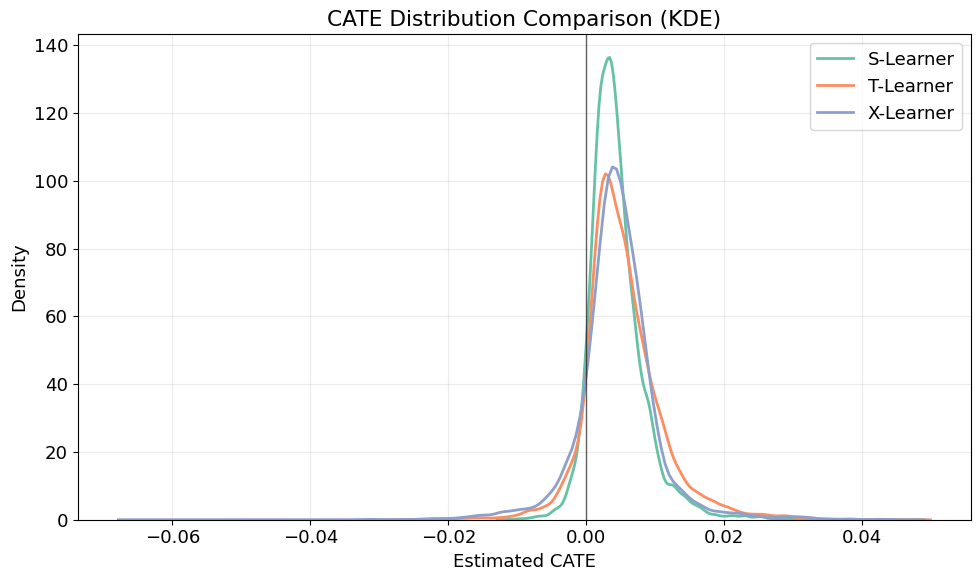

In [14]:
# ======================================================
# Section 4 (Cell 1/1): KDE overlay of CATE distributions
# ======================================================

assert 'cate_s' in globals(), 'Missing cate_s from Section 1'
assert 'cate_t' in globals(), 'Missing cate_t from Section 2'
assert 'cate_x' in globals(), 'Missing cate_x from Section 3'
assert 'figures_dir' in globals(), 'Missing figures_dir from Section 0'

plot_df = pd.DataFrame(
    {
        'S-Learner': np.asarray(cate_s, dtype=float),
        'T-Learner': np.asarray(cate_t, dtype=float),
        'X-Learner': np.asarray(cate_x, dtype=float),
    }
)
assert plot_df.shape[0] == len(X_test), 'Plot dataframe length mismatch'
assert np.isfinite(plot_df.to_numpy()).all(), 'CATE plot data contains NaN/inf'

plt.figure(figsize=(10, 6))
sns.kdeplot(plot_df['S-Learner'], label='S-Learner', linewidth=2)
sns.kdeplot(plot_df['T-Learner'], label='T-Learner', linewidth=2)
sns.kdeplot(plot_df['X-Learner'], label='X-Learner', linewidth=2)

plt.axvline(0, color='black', linewidth=1, alpha=0.6)
plt.title('CATE Distribution Comparison (KDE)')
plt.xlabel('Estimated CATE')
plt.ylabel('Density')
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()

out = figures_dir / 'fig_05_cate_distributions.png'
plt.savefig(out, dpi=150, bbox_inches='tight')
print(f'.png already saved: {out}')
plt.show()


### Section 4 Summary

**Comparison**: S/T/X-Learner 的 CATE 分布对比

- **S-Learner**: CATE 集中在 0 附近（预期内，treatment 信号可能被正则化压缩）
- **T-Learner**: CATE 分布略宽，但通常仍在 [-0.02, 0.02] 的量级范围
- **X-Learner**: CATE 分布更具区分度（利用了 PS 加权和交叉估计）

**注意**: CATE 数值只是各模型预测的业务指标（不能反映模型效果），模型预测能力优劣与否还需通过后续 Qini 评估进行量化。

## Section 5: Mathematical Note — X-Learner Weighting Formula

### Theorem (Künzel)

$$
\tau(x) = (1 - e(x)) \cdot \hat{\tau}_1(x) + e(x) \cdot \hat{\tau}_0(x)
$$

其中：
- $e(x) = P(t=1 \mid x)$ 为倾向性得分（propensity score）
- $\hat{\tau}_1(x)$ 为基于 Treatment 组伪残差训练得到的 CATE 估计
- $\hat{\tau}_0(x)$ 为基于 Control 组伪残差训练得到的 CATE 估计

### 加权逻辑（中文解释）

X-Learner 的核心是"交叉估计 + 加权融合"。当 T:C = 2:1 时，Control 组样本更少，直接用 T-Learner 分别训练两组模型会让少数组的估计更不稳定（方差更大）。

X-Learner 通过伪残差（imputed treatment effects）把 outcome 模型的信息"借"过来：
- Treatment 组：用 Control 的 outcome 模型估计 $\mu_0(x_1)$，得到 $D_1 = Y_1 - \mu_0(x_1)$
- Control 组：用 Treatment 的 outcome 模型估计 $\mu_1(x_0)$，得到 $D_0 = \mu_1(x_0) - Y_0$

然后分别拟合 $\hat{\tau}_1(x)$ 与 $\hat{\tau}_0(x)$，最后用 $e(x)$ 进行加权组合，形成更稳健的最终 CATE。

直觉上可以理解为：让"信息量更少的一侧"的估计在融合时得到更合理的补偿，从而在不平衡样本下获得更低方差、更加稳定的 uplift 排序信号。